<a href="https://colab.research.google.com/github/cbernet/introduction_machine_learning/blob/master/notebooks/deep_learning_intro/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The dog and cats dataset

Here we actually use a subset of the dog and cats dataset.

First, we download a zip file with all images:

In [182]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-10-19 11:57:08--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.71.128, 74.125.133.128, 108.177.15.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.71.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  49.7MB/s    in 1.3s    

2020-10-19 11:57:10 (49.7 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



We extract the zip file to a temporary directory: 

In [183]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Here are the contents of the resulting directory: 


In [185]:
base_dir = '/tmp/cats_and_dogs_filtered'
print(os.listdir(base_dir))
print(os.listdir(os.path.join(base_dir, 'train')))
print(os.listdir(os.path.join(base_dir, 'train', 'cats'))[:5])

['vectorize.py', 'validation', 'train']
['dogs', 'cats']
['cat.106.jpg', 'cat.962.jpg', 'cat.712.jpg', 'cat.84.jpg', 'cat.732.jpg']


Let's display one of the cat images: 

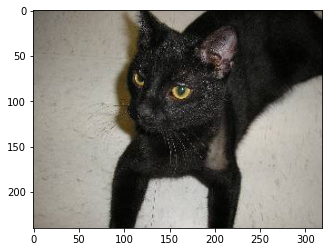

In [186]:
import matplotlib.pyplot as plt
img = plt.imread(os.path.join(base_dir, 'train/cats/cat.962.jpg'))
plt.imshow(img)

## Transfer learning : Construction of the Model

The VGG16 model has been trained on the ImageNet dataset to classify images in 1000 categories. 

This model now knows how to see. 

We will use transfer learning with VGG16 to classify dog and cat images. 

This is a simple alias to the vgg16 keras module: 

In [192]:
vgg16 = tf.keras.applications.vgg16

Let's load the VGG16 model. Here we specify: 

* the model weights. We want the model initialized with the weights learned from the ImageNet dataset;
* the input image shape: 224x224 pixels, and 3 color levels;
* that we want to strip out the dense network at the top of VGG16, as this part is specific to ImageNet classification. We will later replace this part by a custom dense network. 

In [193]:
conv_model = vgg16.VGG16( weights='imagenet', include_top=False, 
                          input_shape=(224,224,3))
conv_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

For now, our model consists of the 5 convolutional blocks of VGG16. 

If we run an image through this model, we will end up with a tensor of 7x7x512 values. In other words, 7x7=49 superpixels, each with 512 features. 

This tensor is an internal representation of the image. 

The model currently has 14 million parameters. There would be no way to train such a complex model from scratch with a few thousand images.

So we will lock all of these layers: 

In [194]:
for layer in conv_model.layers:
    layer.trainable = False

Then, we add at the top of VGG16 our own dense network, designed to classify dogs and cats: 

In [195]:
# flatten the VGG16 output to be able to connect it to a dense layer
x = tf.keras.layers.Flatten()(conv_model.output)
# 3 dense layers with ReLU activation
x = tf.keras.layers.Dense(100, activation='relu')(x)
x = tf.keras.layers.Dense(100, activation='relu')(x)
x = tf.keras.layers.Dense(100, activation='relu')(x)
# classification in 2 categories, dogs and cats
predictions = tf.keras.layers.Dense(2, activation='softmax')(x)
# construction of the full model
full_model = tf.keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()

Model: "functional_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)     

This printout confirms that our model "only" has 2.5 million trainable parameters, mostly coming from the first dense layer. 

We can now compile the model. Empirically, I found out that the Adamax optimizer with this learning rate works well. 

In [196]:
full_model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adamax(lr=0.001),
                  metrics=['acc'])


## Fitting the model

Large image datasets do not fit in memory. 

Fortunately, Keras provides a way to generate batches of examples for the training on the fly: the ImageDataGenerator. 

In [197]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    # All color levels are rescaled by 1./255
    rescale=1./255,
    # Images are preprocessed for vgg16
    preprocessing_function=vgg16.preprocess_input,
    )

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# images will be rescaled to 224x224 pixels, 
# the shape we have chosen for our VGG16 model
img_shape = (224,224)

batch_size = 100

train_generator = datagen.flow_from_directory(
        train_dir,  
        target_size=img_shape,  
        batch_size=batch_size,
        classes=('dogs', 'cats'))

validation_generator = datagen.flow_from_directory(
        validation_dir,
        target_size=img_shape,
        batch_size=batch_size,
        classes=('dogs', 'cats'))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


We see that our training and validation (test) datasets have 2000 and 1000 images, respectively. 

Now we can fit the model: 

In [198]:
history = full_model.fit(
    train_generator, 
    validation_data = validation_generator,
    epochs=5,
)

Epoch 1/5
20/20 [==============================] - 22s 1s/step - loss: 0.6816 - acc: 0.7025 - val_loss: 0.3121 - val_acc: 0.8800
Epoch 2/5
20/20 [==============================] - 21s 1s/step - loss: 0.2270 - acc: 0.9175 - val_loss: 0.2040 - val_acc: 0.9210
Epoch 3/5
20/20 [==============================] - 21s 1s/step - loss: 0.1411 - acc: 0.9465 - val_loss: 0.1812 - val_acc: 0.9300
Epoch 4/5
20/20 [==============================] - 21s 1s/step - loss: 0.0930 - acc: 0.9710 - val_loss: 0.1765 - val_acc: 0.9320
Epoch 5/5
20/20 [==============================] - 21s 1s/step - loss: 0.0650 - acc: 0.9830 - val_loss: 0.1720 - val_acc: 0.9290


If you see that the loss is stuck around 7 or 8, and that the network does not learn: go back and recreate the model from scratch, and try again. 

The model trains fast, and without too much overfitting. 

Indeed, the only thing we train is the last part of the neural net, which interprets the internal representation of VGG16. Overfitting is limited because the number of trainable parameters is relatively small.

Finally, let's have a look at the prediction of the model for a few examples. 

We are going to work on the next batch from the validation dataset: 

In [160]:
batch = validation_generator.next()
images = batch[0]
targets = batch[1]

Here is the first image in the batch. Note that the validation generator has preprocessed the images for VGG16. As a result, the colors are inverted, and the color levels can be negative. 

I just add 0.5 to all color levels so that we can see something. 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


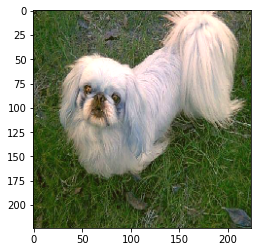

In [200]:
plt.imshow(images[0]+0.5)

Second image: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


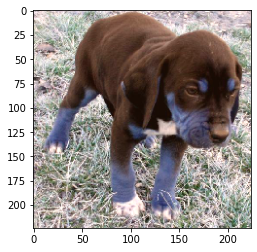

In [180]:
plt.imshow(batch[0][1]+0.5)

Third image: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


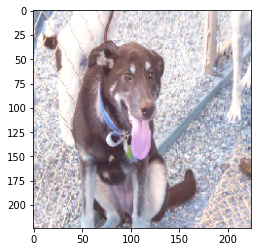

In [181]:
plt.imshow(batch[0][2]+0.5)

And here are the model predictions for these three images: 

In [176]:
full_model.predict(batch[0][:3])

array([[7.6385957e-01, 2.3614039e-01],
       [9.9996650e-01, 3.3547425e-05],
       [9.9792910e-01, 2.0708553e-03]], dtype=float32)

The last two images are clearly identified as dogs. The first one only has a 76% probability to be a dog, but this is understandable when you look at it ;-)